In [1]:
# pip install snntorch --quiet

In [2]:
import snntorch as snn
from snntorch import spikeplot as splt
from snntorch import spikegen

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.autograd import Function
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np
import itertools

import nir

import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [3]:
data_path='/tmp/data/mnist'

In [4]:
#@title Plotting Settings
def plot_mem(mem, ymin=-200, ymax=50, xmax=25, title=False):
  if title:
    plt.title(title)
  plt.plot(mem, 'bo')
  plt.xlabel("Time step")
  plt.ylabel("Membrane Potential")
  plt.xlim([0, xmax])
  plt.ylim([ymin,ymax])
  plt.show()

def plot_step_current_response(cur_in, mem_rec, vline1):
  fig, ax = plt.subplots(2, figsize=(8,6),sharex=True)

  # Plot input current
  ax[0].plot(cur_in, c="tab:orange")
  ax[0].set_ylim([0, 0.2])
  ax[0].set_ylabel("Input Current ($I_{in}$)")
  ax[0].set_title("Lapicque's Neuron Model With Step Input")

  # Plot membrane potential
  ax[1].plot(mem_rec)
  ax[1].set_ylim([0, 0.6]) 
  ax[1].set_ylabel("Membrane Potential ($U_{mem}$)")

  if vline1:
    ax[1].axvline(x=vline1, ymin=0, ymax=2.2, alpha = 0.25, linestyle="dashed", c="black", linewidth=2, zorder=0, clip_on=False)
  plt.xlabel("Time step")

  plt.show()


def plot_current_pulse_response(cur_in, mem_rec, title, vline1=False, vline2=False, ylim_max1=False):

  fig, ax = plt.subplots(2, figsize=(8,6),sharex=True)

  # Plot input current
  ax[0].plot(cur_in, c="tab:orange")
  if not ylim_max1:
    ax[0].set_ylim([0, 0.2])
  else:
    ax[0].set_ylim([0, ylim_max1])
  ax[0].set_ylabel("Input Current ($I_{in}$)")
  ax[0].set_title(title)

  # Plot membrane potential
  ax[1].plot(mem_rec)
  ax[1].set_ylim([0, 1])
  ax[1].set_ylabel("Membrane Potential ($U_{mem}$)")

  if vline1:
    ax[1].axvline(x=vline1, ymin=0, ymax=2.2, alpha = 0.25, linestyle="dashed", c="black", linewidth=2, zorder=0, clip_on=False)
  if vline2:
    ax[1].axvline(x=vline2, ymin=0, ymax=2.2, alpha = 0.25, linestyle="dashed", c="black", linewidth=2, zorder=0, clip_on=False)
  plt.xlabel("Time step")

  plt.show()

def compare_plots(cur1, cur2, cur3, mem1, mem2, mem3, vline1, vline2, vline3, vline4, title):
  # Generate Plots
  fig, ax = plt.subplots(2, figsize=(8,6),sharex=True)

  # Plot input current
  ax[0].plot(cur1)
  ax[0].plot(cur2)
  ax[0].plot(cur3)
  ax[0].set_ylim([0, 0.2])
  ax[0].set_ylabel("Input Current ($I_{in}$)")
  ax[0].set_title(title)

  # Plot membrane potential
  ax[1].plot(mem1)
  ax[1].plot(mem2)
  ax[1].plot(mem3)
  ax[1].set_ylim([0, 1])
  ax[1].set_ylabel("Membrane Potential ($U_{mem}$)")

  ax[1].axvline(x=vline1, ymin=0, ymax=2.2, alpha = 0.25, linestyle="dashed", c="black", linewidth=2, zorder=0, clip_on=False)
  ax[1].axvline(x=vline2, ymin=0, ymax=2.2, alpha = 0.25, linestyle="dashed", c="black", linewidth=2, zorder=0, clip_on=False)
  ax[1].axvline(x=vline3, ymin=0, ymax=2.2, alpha = 0.25, linestyle="dashed", c="black", linewidth=2, zorder=0, clip_on=False)
  ax[1].axvline(x=vline4, ymin=0, ymax=2.2, alpha = 0.25, linestyle="dashed", c="black", linewidth=2, zorder=0, clip_on=False)

  plt.xlabel("Time step")

  plt.show()

def plot_cur_mem_spk(cur, mem, spk, thr_line=False, vline=False, title=False, ylim_max2=1.25):
  # Generate Plots
  fig, ax = plt.subplots(3, figsize=(8,6), sharex=True, 
                        gridspec_kw = {'height_ratios': [1, 1, 0.4]})

  # Plot input current
  ax[0].plot(cur, c="tab:orange")
  ax[0].set_ylim([0, 0.4])
  ax[0].set_xlim([0, 200])
  ax[0].set_ylabel("Input Current ($I_{in}$)")
  if title:
    ax[0].set_title(title)

  # Plot membrane potential
  ax[1].plot(mem)
  ax[1].set_ylim([0, ylim_max2]) 
  ax[1].set_ylabel("Membrane Potential ($U_{mem}$)")
  if thr_line:
    ax[1].axhline(y=thr_line, alpha=0.25, linestyle="dashed", c="black", linewidth=2)
  plt.xlabel("Time step")

  # Plot output spike using spikeplot
  splt.raster(spk, ax[2], s=400, c="black", marker="|")
  if vline:
    ax[2].axvline(x=vline, ymin=0, ymax=6.75, alpha = 0.15, linestyle="dashed", c="black", linewidth=2, zorder=0, clip_on=False)
  plt.ylabel("Output spikes")
  plt.yticks([]) 

  plt.show()

def plot_spk_mem_spk(spk_in, mem, spk_out, title):
  # Generate Plots
  fig, ax = plt.subplots(3, figsize=(8,6), sharex=True, 
                        gridspec_kw = {'height_ratios': [0.4, 1, 0.4]})

  # Plot input current
  splt.raster(spk_in, ax[0], s=400, c="black", marker="|")
  ax[0].set_ylabel("Input Spikes")
  ax[0].set_title(title)
  plt.yticks([]) 

  # Plot membrane potential
  ax[1].plot(mem)
  ax[1].set_ylim([0, 1])
  ax[1].set_ylabel("Membrane Potential ($U_{mem}$)")
  ax[1].axhline(y=0.5, alpha=0.25, linestyle="dashed", c="black", linewidth=2)
  plt.xlabel("Time step")

  # Plot output spike using spikeplot
  splt.raster(spk_rec, ax[2], s=400, c="black", marker="|")
  plt.ylabel("Output spikes")
  plt.yticks([]) 

  plt.show()


def plot_reset_comparison(spk_in, mem_rec, spk_rec, mem_rec0, spk_rec0):
  # Generate Plots to Compare Reset Mechanisms
  fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(10,6), sharex=True, 
                        gridspec_kw = {'height_ratios': [0.4, 1, 0.4], 'wspace':0.05})

  # Reset by Subtraction: input spikes
  splt.raster(spk_in, ax[0][0], s=400, c="black", marker="|")
  ax[0][0].set_ylabel("Input Spikes")
  ax[0][0].set_title("Reset by Subtraction")
  ax[0][0].set_yticks([])

  # Reset by Subtraction: membrane potential 
  ax[1][0].plot(mem_rec)
  ax[1][0].set_ylim([0, 0.7])
  ax[1][0].set_ylabel("Membrane Potential ($U_{mem}$)")
  ax[1][0].axhline(y=0.5, alpha=0.25, linestyle="dashed", c="black", linewidth=2)

  # Reset by Subtraction: output spikes
  splt.raster(spk_rec, ax[2][0], s=400, c="black", marker="|")
  ax[2][0].set_yticks([])
  ax[2][0].set_xlabel("Time step")
  ax[2][0].set_ylabel("Output Spikes")

  # Reset to Zero: input spikes
  splt.raster(spk_in, ax[0][1], s=400, c="black", marker="|")
  ax[0][1].set_title("Reset to Zero")
  ax[0][1].set_yticks([])

  # Reset to Zero: membrane potential
  ax[1][1].plot(mem_rec0)
  ax[1][1].set_ylim([0, 0.7])
  ax[1][1].axhline(y=0.5, alpha=0.25, linestyle="dashed", c="black", linewidth=2)
  ax[1][1].set_yticks([])
  ax[2][1].set_xlabel("Time step")

  # Reset to Zero: output spikes
  splt.raster(spk_rec0, ax[2][1], s=400, c="black", marker="|")
  ax[2][1].set_yticks([])

  plt.show()

In [5]:
# define transforms
transform = transforms.Compose([
            transforms.Resize((16, 16)),
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize((0,), (1,))])

# generate training and test data
mnist_train = datasets.MNIST(data_path, train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(data_path, train=False, download=True, transform=transform)
mnist_whole = datasets.MNIST(data_path, download=True, transform=transform)

In [6]:
# train in batch sizes of x images
batch_size = 128

# configure device
dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# create dataloader objects
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True
                          , drop_last=True
                         )
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True
                         , drop_last=True
                         )

In [7]:
# Custom Binarized model
class Binarize(Function):
  @staticmethod
  def forward(weight_ref, input):
    return input.sign().clamp(min=-1) # convert input to -1 or 1

  @staticmethod
  def backward(weight_ref, gradient_out):
    gradient_in = gradient_out.clone() # create clone of weights for STE
    return gradient_in

class BinaryLinear(nn.Linear):
    def forward(self, input):
        bin_weights = Binarize.apply(self.weight)
        if self.bias is None:
            return F.linear(input, bin_weights)
        else:
            return F.linear(input, bin_weights, self.bias)

    def reset_parameters(self):
        # Apply Xavier normal initialization
        torch.nn.init.xavier_normal_(self.weight)
        if self.bias is not None:
            # Initialize bias to zero
            torch.nn.init.constant_(self.bias, 0)

In [8]:
# Network Architecture
# number of pixels
# num_inputs = 28*28
num_inputs = 16*16
# number of neurons in hidden layer
num_hidden_1 = 150
num_hidden_2 = 100
num_hidden_3 = 50
# output classes
num_outputs = 10

# Temporal Dynamics
num_steps = 30
beta = 1
thresh = 8

In [9]:
# Define Network
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        # Initialize layers
        self.fc1 = BinaryLinear(num_inputs, num_hidden_1)
        self.lif1 = snn.Leaky(beta=beta
                              # ,reset_mechanism="zero"
                              , threshold=thresh
                             )
        self.fc2 = BinaryLinear(num_hidden_1, num_hidden_2)
        self.lif2 = snn.Leaky(beta=beta
                              # ,reset_mechanism="zero"
                              , threshold=thresh
                              )
        self.fc3 = BinaryLinear(num_hidden_2, num_hidden_3)
        self.lif3 = snn.Leaky(beta = beta
                              #, reset_mechanism="zero"
                              , threshold = thresh
                             )
        self.fc4 = BinaryLinear(num_hidden_3, num_outputs)
        self.lif4 = snn.Leaky(beta = beta
                              #, reset_mechanism="zero"
                              , threshold = thresh
                              )

#         self.fc1 = BinaryLinear(num_inputs, num_outputs)
#         self.lif1 = snn.Leaky(beta=beta
#                               # ,reset_mechanism="zero"
#                               , threshold=thresh
#                              )

    def forward(self, x):

        # Initialize hidden states at t=0
        # mem1 = self.lif1.init_leaky()
        # mem2 = self.lif2.init_leaky()
        # mem3 = self.lif3.init_leaky()

        # # Record the final layer
        # cur1_rec = []
        # cur2_rec = []
        # cur3_rec = []
        
        # spk1_rec = []
        # mem1_rec = []
        
        # spk2_rec = []
        # mem2_rec = []

        # spk3_rec = []
        # mem3_rec = []
        
        # for step in range(num_steps):
        #     #cur1 = self.fc1(x[step])
        #     cur1 = self.fc1(x)
        #     cur1_rec.append(cur1)
            
        #     spk1, mem1 = self.lif1(cur1, mem1)
        #     spk1_rec.append(spk1)
        #     mem1_rec.append(mem1)
            
        #     cur2 = self.fc2(spk1)
        #     cur2_rec.append(cur2)
            
        #     spk2, mem2 = self.lif2(cur2, mem2)
        #     spk2_rec.append(spk2)
        #     mem2_rec.append(mem2)

        #     cur3 = self.fc3(spk2)
        #     cur3_rec.append(cur3)

        #     spk3, mem3 = self.lif3(cur3, mem3)
        #     spk3_rec.append(spk3)
        #     mem3_rec.append(mem3)

        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        mem3 = self.lif3.init_leaky()
        mem4 = self.lif4.init_leaky()

        # # Record the layer
        cur1_rec = []
        spk1_rec = []
        mem1_rec = []
        
        cur2_rec = []
        spk2_rec = []
        mem2_rec = []
        
        cur3_rec = []
        spk3_rec = []
        mem3_rec = []
        
        cur4_rec = []
        spk4_rec = []
        mem4_rec = []
        
        for step in range(num_steps):
            cur1 = self.fc1(x)
            spk1, mem1 = self.lif1(cur1, mem1)
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)
            cur3 = self.fc3(spk2)
            spk3, mem3 = self.lif3(cur3, mem3)
            cur4 = self.fc4(spk3)
            spk4, mem4 = self.lif4(cur4, mem4)
            spk4_rec.append(spk4)
            mem4_rec.append(mem4)
            cur4_rec.append(cur4)
            
        
        # spk2_rec = self.fc3(spk2)
        # mem2_rec = self.lif2(cur3, mem3)
        # return torch.stack(spk3_rec, dim=0), torch.stack(mem3_rec, dim=0), \
        #        torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0), \
        #        torch.stack(spk1_rec, dim=0), torch.stack(mem1_rec, dim=0), \
        #        torch.stack(cur3_rec, dim=0), torch.stack(cur2_rec, dim=0), torch.stack(cur1_rec, dim=0)

        return torch.stack(spk4_rec, dim=0), torch.stack(mem4_rec, dim=0), torch.stack(cur4_rec, dim=0)

        # return torch.stack(spk3_rec, dim=0), torch.stack(mem3_rec, dim=0)
        #return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)
 
        #return spk2_rec, mem2_rec

# Load the network onto CUDA if available
net = Net().to(device)

In [10]:
# Accuracy Metrics:
# pass data into the network, sum the spikes over time
# and compare the neuron with the highest number of spikes
# with the target

def print_batch_accuracy(data, targets, train=False):
    #batch_test_spiketrain = spikegen.rate(data.view(batch_size,-1), num_steps=num_steps)
    batch_test_spiketrain = spikegen.rate(data.view(batch_size,-1), num_steps=1)
    #print(batch_test_spiketrain.size())
    batch_out = []
#    for i in range(num_steps):
    #batch_output, _, _, _, _, _, _, _, _ = net(batch_test_spiketrain)
    # batch_output, _, _, _, _, _, _, _, _ = net(batch_test_spiketrain[0])
    batch_output, _, _ = net(batch_test_spiketrain[0])
    # batch_output, _ = net(batch_test_spiketrain[0])
    #print(batch_output.size())
    #output = torch.cat(batch_output, dim=1)
    output = batch_output
    #print(output.size())
    _, idx = output.sum(dim=0).max(1)
    acc = np.mean((targets == idx).detach().cpu().numpy())

    if train:
        print(f"Train set accuracy for a single minibatch: {acc*100:.2f}%")
    else:
        print(f"Test set accuracy for a single minibatch: {acc*100:.2f}%")

def train_printer(
    data, targets, epoch,
    counter, iter_counter,
        loss_hist, test_loss_hist, test_data, test_targets):
    print(f"Epoch {epoch}, Iteration {iter_counter}")
    print(f"Train Set Loss: {loss_hist[counter]:.2f}")
    print(f"Test Set Loss: {test_loss_hist[counter]:.2f}")
    print_batch_accuracy(data, targets, train=True)
    print_batch_accuracy(test_data, test_targets, train=False)
    print("\n")

In [11]:
# configure loss
loss = nn.CrossEntropyLoss()

# set up optimizer
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3, betas=(0.9, 0.999))

In [12]:
# train the SNN

num_epochs = 10
loss_hist = []
test_loss_hist = []
counter = 0

# Outer training loop
for epoch in range(num_epochs):
    iter_counter = 0
    train_batch = iter(train_loader)

    # Minibatch training loop
    for data, targets in train_batch:
        data = data.to(device)
        targets = targets.to(device)

        # forward pass
        net.train()
        # input_spiketrain = spikegen.rate(data.view(batch_size, -1), num_steps=num_steps)
        input_spiketrain = spikegen.rate(data.view(batch_size, -1), num_steps=1)
        spk_tot = []
        mem_tot = []
        #for i in range(num_steps):
        #spk_slice, mem_slice, _, _, _, _, _, _, _ = net(input_spiketrain)
        # spk_slice, mem_slice, _, _, _, _, _, _, _ = net(input_spiketrain[0])
        spk_slice, mem_slice, _ = net(input_spiketrain[0])
        # spk_slice, mem_slice = net(input_spiketrain[0])
        #    spk_tot.append(spk_slice)
        #    mem_tot.append(mem_slice)
            
        spk_rec = spk_slice
        mem_rec = mem_slice

        # initialize the loss & sum over time
        loss_val = torch.zeros((1), dtype=dtype, device=device)
        for step in range(num_steps):
            loss_val += loss(mem_rec[step], targets)

        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())

        # Test set
        with torch.no_grad():
            net.eval()
            test_data, test_targets = next(iter(test_loader))
            test_data = test_data.to(device)
            test_targets = test_targets.to(device)

            # Test set forward pass
            #test_t_spiketrain = spikegen.rate(test_data.view(batch_size,-1), num_steps=num_steps)
            test_t_spiketrain = spikegen.rate(test_data.view(batch_size,-1), num_steps=1)
            spk_test_tot = []
            mem_test_tot = []
            # for i in range(num_steps):
            #  spk_tst, mem_tst, _, _, _, _, _, _, _ = net(test_t_spiketrain)
            # spk_tst, mem_tst, _, _, _, _, _, _, _ = net(test_t_spiketrain[0])
            
            # spk_tst, mem_tst = net(test_t_spiketrain[0])
            #    spk_test_tot.append(spk_tst)
            #    mem_test_tot.append(mem_tst)
            test_spk = spk_test_tot
            test_mem = mem_test_tot

            #test_spk, test_mem, _, _, _, _, _, _, _ = net(test_t_spiketrain)
            # test_spk, test_mem, _, _, _, _, _, _, _ = net(test_t_spiketrain[0])
            test_spk, test_mem, _ = net(test_t_spiketrain[0])
            # test_spk, test_mem = net(test_t_spiketrain[0])
            # Test set loss
            test_loss = torch.zeros((1), dtype=dtype, device=device)
            for step in range(num_steps):
                test_loss += loss(test_mem[step], test_targets)
            test_loss_hist.append(test_loss.item())

            # Print train/test loss/accuracy
            if counter % 50 == 0:
                train_printer(
                    data, targets, epoch,
                    counter, iter_counter,
                    loss_hist, test_loss_hist,
                    test_data, test_targets)
            counter += 1
            iter_counter +=1

Epoch 0, Iteration 0
Train Set Loss: 417.68
Test Set Loss: 355.87
Train set accuracy for a single minibatch: 7.03%
Test set accuracy for a single minibatch: 14.06%


Epoch 0, Iteration 50
Train Set Loss: 153.82
Test Set Loss: 175.11
Train set accuracy for a single minibatch: 40.62%
Test set accuracy for a single minibatch: 42.19%


Epoch 0, Iteration 100
Train Set Loss: 117.39
Test Set Loss: 200.79
Train set accuracy for a single minibatch: 55.47%
Test set accuracy for a single minibatch: 52.34%


Epoch 0, Iteration 150
Train Set Loss: 90.38
Test Set Loss: 74.90
Train set accuracy for a single minibatch: 60.94%
Test set accuracy for a single minibatch: 67.19%


Epoch 0, Iteration 200
Train Set Loss: 76.59
Test Set Loss: 102.87
Train set accuracy for a single minibatch: 62.50%
Test set accuracy for a single minibatch: 56.25%


Epoch 0, Iteration 250
Train Set Loss: 95.19
Test Set Loss: 50.89
Train set accuracy for a single minibatch: 67.19%
Test set accuracy for a single minibatch: 62.5

Epoch 5, Iteration 160
Train Set Loss: 36.00
Test Set Loss: 39.16
Train set accuracy for a single minibatch: 83.59%
Test set accuracy for a single minibatch: 89.06%


Epoch 5, Iteration 210
Train Set Loss: 46.79
Test Set Loss: 43.20
Train set accuracy for a single minibatch: 84.38%
Test set accuracy for a single minibatch: 84.38%


Epoch 5, Iteration 260
Train Set Loss: 40.96
Test Set Loss: 42.86
Train set accuracy for a single minibatch: 89.06%
Test set accuracy for a single minibatch: 89.06%


Epoch 5, Iteration 310
Train Set Loss: 39.36
Test Set Loss: 33.16
Train set accuracy for a single minibatch: 85.16%
Test set accuracy for a single minibatch: 90.62%


Epoch 5, Iteration 360
Train Set Loss: 56.29
Test Set Loss: 21.83
Train set accuracy for a single minibatch: 87.50%
Test set accuracy for a single minibatch: 93.75%


Epoch 5, Iteration 410
Train Set Loss: 31.25
Test Set Loss: 47.16
Train set accuracy for a single minibatch: 92.97%
Test set accuracy for a single minibatch: 82.81%


In [13]:
#test = snn.import_from_nir(nir_model)
#print(test)
#print(net)
test = net

In [14]:
total = 0
correct = 0

# drop_last switched to False to keep all samples
test_loader = DataLoader(mnist_whole, batch_size=batch_size, shuffle=True, drop_last=True)
m1_verif = []
s1_verif = []

m2_verif = []
s2_verif = []

m3_verif = []
s3_verif = []

i1_verif = []
i2_verif = []
i3_verif = []

with torch.no_grad():
  test.eval()
  for data, targets in test_loader:
    data = data.to(device)
    targets = targets.to(device)
    
    # forward pass
    #test_spiketrain = spikegen.rate(data.view(batch_size, -1), num_steps=num_steps)
    test_spiketrain = spikegen.rate(data.view(batch_size, -1), num_steps=1)
    #test_spk3, test_mem3, test_spk2, test_mem2, test_spk1, test_mem1, test_i3, test_i2, test_i1  = test(test_spiketrain)
    # test_spk3, test_mem3, test_spk2, test_mem2, test_spk1, test_mem1, test_i3, test_i2, test_i1  = test(test_spiketrain[0])
    test_spk1, test_mem1, test_cur1 = test(test_spiketrain[0])
    # test_spk3, test_mem3 = test(test_spiketrain[0])
    
#     m3_verif.append(test_mem3)
#     s3_verif.append(test_spk3)
      
#     m2_verif.append(test_mem2)
#     s2_verif.append(test_spk2)
    
    m1_verif.append(test_mem1)
    s1_verif.append(test_spk1)
    
#     i3_verif.append(test_i3)
#     i2_verif.append(test_i2)
    i1_verif.append(test_cur1)
      
    # calculate total accuracy
    # _, predicted = test_spk3.sum(dim=0).max(1)
    _, predicted = test_spk1.sum(dim=0).max(1)
    total += targets.size(0)
    correct += (predicted == targets).sum().item()

#membrane_pot = torch.stack(membrane_verif)
#plot_mem(membrane_verif, "Potential over timesteps")

print(f"Total correctly classified test set images: {correct}/{total}")
print(f"Test Set Accuracy: {100 * correct / total:.2f}%")

Total correctly classified test set images: 45280/59904
Test Set Accuracy: 75.59%


In [15]:
i = 1
disp_v = m2_verif[i]
disp_spk = s2_verif[i]
disp_inp = i2_verif[i]
print(disp_inp[:,0,0])
print(disp_v[:,0,0])
print(disp_spk[:,0,0])
plot_mem(disp_inp[:,0,0], ymin=-50, ymax=50, title="Input Current Plot")
plot_mem(disp_v[:,0,0], ymin=-75, ymax=175, title="Membrane Voltage Plot")
plot_mem(disp_spk[:,0,0], ymin=0, ymax=2, title="Spike Output Plot")

IndexError: list index out of range

In [16]:
sample_data = torch.randn(10, 50, 100, 150,  256)

In [17]:
nir_model = snn.export_to_nir(net, sample_data=sample_data)

RuntimeError: [enforce fail at alloc_cpu.cpp:114] data. DefaultCPUAllocator: not enough memory: you tried to allocate 4500000000 bytes.

In [27]:
for i in nir_model.nodes:
    if(str(i).startswith("fc")):
        ctr = 0;
        for j in nir_model.nodes.get(i).weight:
            nir_model.nodes.get(i).weight[ctr] = torch.Tensor.numpy(Binarize.forward(0, torch.from_numpy(j)))
            ctr += 1

In [35]:
print(nir_model.nodes.get("fc1"))

Affine(weight=array([[-1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [-1.,  1., -1., ..., -1.,  1., -1.],
       ...,
       [-1.,  1., -1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ..., -1., -1., -1.],
       [ 1., -1.,  1., ...,  1., -1., -1.]], dtype=float32), bias=array([-0.40648434,  1.1392531 , -0.16827479, -0.30009788,  0.371787  ,
        0.38945776,  0.02637405,  0.3280624 , -0.67636466,  0.05009126,
       -0.10651901, -0.06386936, -0.06595652, -0.07119026, -0.09108058,
       -0.09548624, -0.0616105 , -0.06753255, -0.07969771, -0.06242264,
       -0.06586924, -0.06667829, -0.09203003, -0.12124414, -0.0790769 ,
       -0.09613211, -0.06154506, -0.07506762, -0.09168278, -0.06276088,
       -0.08064882, -0.07336035, -0.06540553, -0.074495  , -0.07617415,
       -0.08995645, -0.07812404, -0.08051247, -0.08858483, -0.10489845,
       -0.08054807, -0.056754  , -0.07875501, -0.06241516, -0.10168274,
       -0.06380145, -0.09227289, -0.0812

In [33]:
print(((nir_model.nodes.get("fc1"))))

Affine(weight=array([[-1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [-1.,  1., -1., ..., -1.,  1., -1.],
       ...,
       [-1.,  1., -1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ..., -1., -1., -1.],
       [ 1., -1.,  1., ...,  1., -1., -1.]], dtype=float32), bias=array([-0.40648434,  1.1392531 , -0.16827479, -0.30009788,  0.371787  ,
        0.38945776,  0.02637405,  0.3280624 , -0.67636466,  0.05009126,
       -0.10651901, -0.06386936, -0.06595652, -0.07119026, -0.09108058,
       -0.09548624, -0.0616105 , -0.06753255, -0.07969771, -0.06242264,
       -0.06586924, -0.06667829, -0.09203003, -0.12124414, -0.0790769 ,
       -0.09613211, -0.06154506, -0.07506762, -0.09168278, -0.06276088,
       -0.08064882, -0.07336035, -0.06540553, -0.074495  , -0.07617415,
       -0.08995645, -0.07812404, -0.08051247, -0.08858483, -0.10489845,
       -0.08054807, -0.056754  , -0.07875501, -0.06241516, -0.10168274,
       -0.06380145, -0.09227289, -0.0812

In [25]:
print((nir_model.nodes.get("fc2").bias))

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [26]:
nir.write("TEST5Layer.nir", nir_model)

In [36]:
# Define Network
class Test(nn.Module):
    def __init__(self):
        super().__init__()        # Initialize layers
        self.fc1 = BinaryLinear(1, 1)
        self.lif1 = snn.Leaky(beta=0.1
                              , reset_mechanism="subtract"
                              , threshold=1.5
                              , output=True
                             )
        self.fc2 = BinaryLinear(1, 1)
        self.lif2 = snn.Leaky(beta=0.1
                              , reset_mechanism="subtract"
                              , threshold=3
                              , output=True
                              )

    def forward(self, x):

        # Initialize hidden states at t=0
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()

        # Record the final layer
        cur1_rec = []        
        spk1_rec = []
        mem1_rec = []

        cur2_rec = []
        spk2_rec = []
        mem2_rec = []

        for step in range(50):
            cur1 = self.fc1(x)
            cur1_rec.append(cur1)
            
            spk1, mem1 = self.lif1(cur1, mem1)
            spk1_rec.append(spk1)
            mem1_rec.append(mem1)
            
            cur2 = self.fc2(spk1)
            cur2_rec.append(cur2)
            
            spk2, mem2 = self.lif2(cur2, mem2)
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)
            
        #cur1 = self.fc1(x)
        #spk1, mem1 = self.lif1(cur1, mem1)
        #cur2 = self.fc2(spk1)
        #spk2, mem2 = self.lif2(cur2, mem2)
        #spk2_rec = spk2
        #mem2_rec = mem2
        
        return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0), \
               torch.stack(spk1_rec, dim=0), torch.stack(mem1_rec, dim=0), \
               torch.stack(cur2_rec, dim=0), torch.stack(cur1_rec, dim=0)

        # return torch.stack(spk3_rec, dim=0), torch.stack(mem3_rec, dim=0)
        #return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)
 
        #return spk2_rec, mem2_rec

# Load the network onto CUDA if available
test_lif = Test().to(device)

In [37]:
print(test_lif)

Test(
  (fc1): BinaryLinear(in_features=1, out_features=1, bias=True)
  (lif1): Leaky()
  (fc2): BinaryLinear(in_features=1, out_features=1, bias=True)
  (lif2): Leaky()
)


In [38]:
with torch.no_grad():
  test_lif.eval()
  test_in = torch.tensor([-1], dtype=torch.float)
  test_lif_spk2, test_lif_mem2, test_lif_spk1, test_lif_mem1, test_lif_cur2, test_lif_cur1 = test_lif(test_in)

tensor([[1.0000],
        [1.1000],
        [1.1100],
        [1.1110],
        [1.1111],
        [1.1111],
        [1.1111],
        [1.1111],
        [1.1111],
        [1.1111],
        [1.1111],
        [1.1111],
        [1.1111],
        [1.1111],
        [1.1111],
        [1.1111],
        [1.1111],
        [1.1111],
        [1.1111],
        [1.1111],
        [1.1111],
        [1.1111],
        [1.1111],
        [1.1111],
        [1.1111],
        [1.1111],
        [1.1111],
        [1.1111],
        [1.1111],
        [1.1111],
        [1.1111],
        [1.1111],
        [1.1111],
        [1.1111],
        [1.1111],
        [1.1111],
        [1.1111],
        [1.1111],
        [1.1111],
        [1.1111],
        [1.1111],
        [1.1111],
        [1.1111],
        [1.1111],
        [1.1111],
        [1.1111],
        [1.1111],
        [1.1111],
        [1.1111],
        [1.1111]])


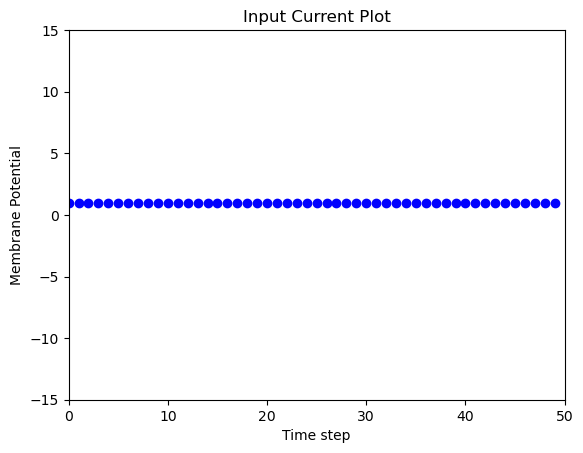

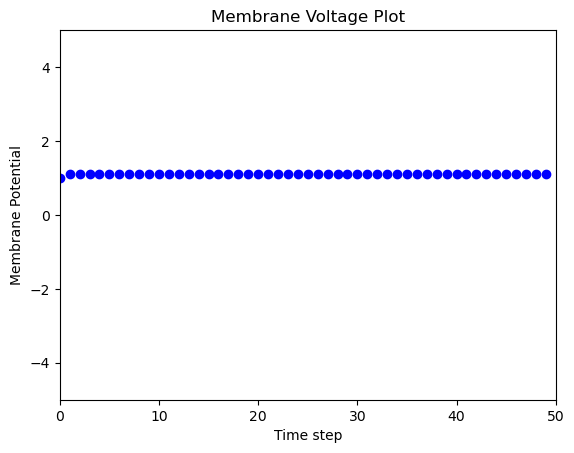

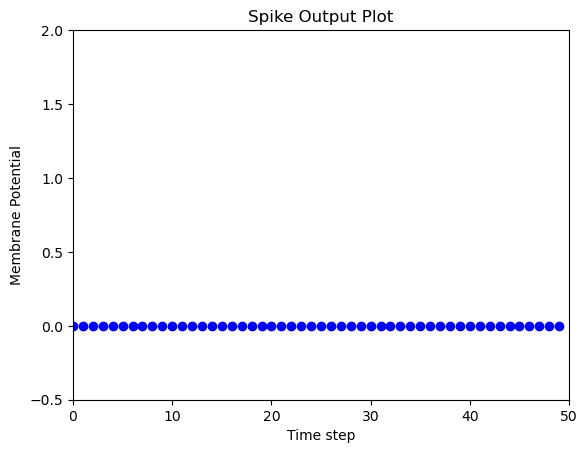

In [39]:
# print(test_lif_cur1)
print(test_lif_mem1)
# print(test_lif_spk1)
plot_mem(test_lif_cur1, ymin=-15,   ymax=15, xmax=50, title="Input Current Plot")
plot_mem(test_lif_mem1, ymin=-5, ymax=5, xmax=50, title="Membrane Voltage Plot")
plot_mem(test_lif_spk1, ymin=-0.5, ymax=2, xmax=50, title="Spike Output Plot")

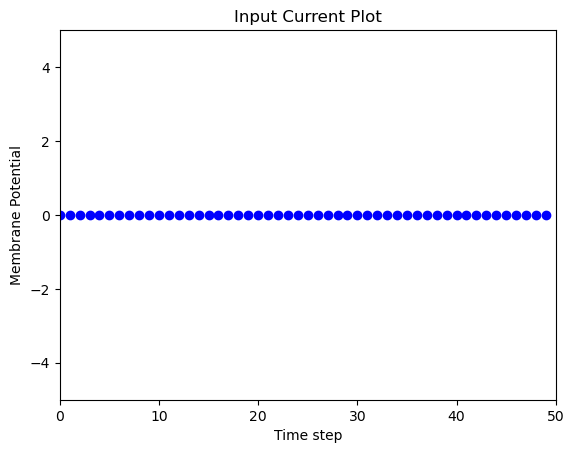

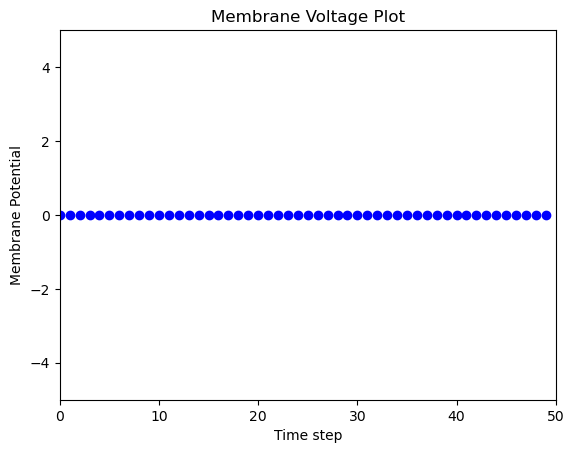

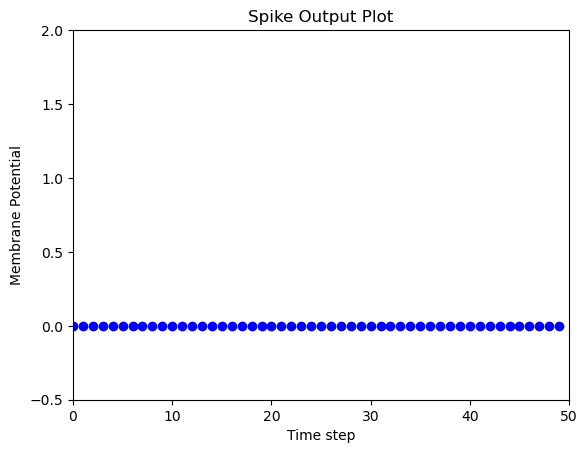

In [1261]:
plot_mem(test_lif_cur2, ymin=-5, ymax=5, xmax=50, title="Input Current Plot")
plot_mem(test_lif_mem2, ymin=-5, ymax=5, xmax=50, title="Membrane Voltage Plot")
plot_mem(test_lif_spk2, ymin=-0.5, ymax=2, xmax=50, title="Spike Output Plot")

In [1263]:
test_model = snn.export_to_nir(test_lif, sample_data=test_in)
print(test_model)

NIRGraph(nodes={'input': Input(input_type={'input': array([1])}), 'fc1': Affine(weight=array([[0.04010493]], dtype=float32), bias=array([0.], dtype=float32), input_type={'input': array([1])}, output_type={'output': array([1])}, metadata={}), 'lif1': LIF(tau=0.0002, r=2.0, v_leak=array(0., dtype=float32), v_threshold=array(5, dtype=int64), input_type={'input': array([], dtype=float64)}, output_type={'output': array([], dtype=float64)}, metadata={}), 'fc2': Affine(weight=array([[0.27312118]], dtype=float32), bias=array([0.], dtype=float32), input_type={'input': array([1])}, output_type={'output': array([1])}, metadata={}), 'lif2': LIF(tau=0.0002, r=2.0, v_leak=array(0., dtype=float32), v_threshold=array(3, dtype=int64), input_type={'input': array([], dtype=float64)}, output_type={'output': array([], dtype=float64)}, metadata={}), 'output': Output(output_type={'output': array([1])})}, edges=[('lif2', 'output'), ('lif1', 'fc2'), ('fc2', 'lif2'), ('fc1', 'lif1'), ('input', 'fc1')], input_ty

In [ ]:
Affine(
    weight=array([[ 1.,  1., -1., ..., -1., -1.,  1.],
       [ 1.,  1., -1., ..., -1., -1., -1.],
       [-1.,  1.,  1., ..., -1.,  1.,  1.],
       ...,
       [-1., -1., -1., ..., -1., -1.,  1.],
       [ 1.,  1., -1., ..., -1.,  1., -1.],
       [-1., -1., -1., ...,  1., -1.,  1.]], dtype=float32),
    bias=array([ 0.1009215 ,  0.01056621,  0.04929107, -0.0332957 , -0.03695581,
        0.03904731,  0.0197216 , -0.07571533,  0.05091662,  0.08878961,
        0.01564536,  0.05161016,  0.06772061,  0.0632091 ,  0.02623171,
       -0.05013173,  0.02469478,  0.0404999 ,  0.08496135,  0.01402613,
        0.07954828,  0.03962149,  0.04144652, -0.07856443,  0.02252836,
        0.01329264, -0.02184459, -0.01157423,  0.05655716,  0.04655876,
        0.02352429,  0.06137991,  0.06815517,  0.01155421,  0.01147448,
        0.03722914,  0.04600598, -0.0073339 ,  0.04141028,  0.00146396,
       -0.0383213 ,  0.02292555, -0.00051601, -0.02771499, -0.03703493,
        0.04732281,  0.00766984, -0.05779942,  0.02206175,  0.03283292,
        0.05404404,  0.05544268, -0.03703262,  0.02228428,  0.12030443,
        0.00716768,  0.03350221, -0.03384176,  0.07111918,  0.06375866,
        0.06401234,  0.01839542,  0.04442194,  0.05609976,  0.01979149,
        0.03706134, -0.01640035, -0.04544761,  0.05218566,  0.11039118,
       -0.00209426,  0.04198991,  0.10689857,  0.09557332,  0.09015911,
        0.0064611 , -0.0013184 ,  0.0154663 ,  0.0777692 ,  0.02402217,
        0.0268336 ,  0.01880237,  0.03845166,  0.05565656,  0.08355922,
       -0.06279235,  0.03985051, -0.03999543,  0.03747547,  0.07245038,
        0.00344533,  0.014121  , -0.00683245,  0.06389244,  0.0659066 ,
        0.03508978,  0.0443225 ,  0.09641098, -0.08349199, -0.04515573,
        0.06336527,  0.0041139 , -0.01503064, -0.00505937, -0.02682389,
        0.08607724,  0.06691478, -0.08266222,  0.03992905,  0.10163339,
       -0.00770793,  0.07837504,  0.02225685,  0.05250541,  0.08909381,
        0.02886833, -0.03612163, -0.01325568,  0.05510648,  0.00239697,
        0.05198224, -0.02760084,  0.02568853, -0.01226529, -0.01560187,
       -0.02417283, -0.04900137, -0.06605668,  0.05759297, -0.04377581,
       -0.05016879, -0.07030804,  0.0689007 ,  0.008381  ,  0.01178456,
       -0.02010161,  0.05507733, -0.01015529,  0.00208677,  0.0359959 ,
        0.01760789,  0.03947135, -0.00360024, -0.07412802, -0.01526334,
       -0.01073579, -0.05350151, -0.00946829, -0.04080444, -0.08862601,
       -0.01905126,  0.02373825,  0.02561951,  0.01501931, -0.00516778,
        0.02493444,  0.05075564, -0.01322739, -0.02902855, -0.1127844 ,
       -0.00602325, -0.03932552,  0.00220306, -0.00974231,  0.06671224,
       -0.01214928,  0.01339486,  0.06013608, -0.0531178 ,  0.04542631,
        0.03016868, -0.04219029,  0.07481925,  0.0727564 , -0.01565988,
       -0.01174347, -0.06760536, -0.00660002,  0.06531591, -0.01187729,
        0.04688989, -0.05211253, -0.06112675,  0.00553037,  0.05430356,
        0.02847206,  0.12328246, -0.01823531,  0.09615794, -0.05857543,
        0.04499691,  0.04760434,  0.05337632,  0.06946445, -0.03134006,
        0.0313275 ,  0.03067483,  0.01288446, -0.03583638,  0.05112115,
        0.05633372, -0.04109506, -0.06682277,  0.1041477 ,  0.03991095,
       -0.04537598,  0.06061276, -0.01500979,  0.01395738,  0.10575601,
        0.02338696, -0.05161939, -0.01893329,  0.05781336,  0.02891826,
       -0.03324988,  0.07301032, -0.07468474, -0.07354445,  0.03644063,
       -0.03213177,  0.02539858,  0.08209603,  0.02195088, -0.01625294,
        0.01847285, -0.00574548, -0.0283527 ,  0.06356864,  0.07001008,
       -0.04465934,  0.02699364,  0.01516743,  0.03485133,  0.05516924,
        0.01876684,  0.04320775,  0.0415695 ,  0.08099367,  0.11294322,
        0.07247799,  0.06351856, -0.01124045,  0.10493372,  0.00753347,
       -0.03757563,  0.0159433 , -0.0439716 , -0.08869992,  0.03093558,
       -0.05897093,  0.02038252,  0.0390482 ,  0.01463429, -0.05734879,
        0.07094757], dtype=float32), input_type={'input': array([784])}, output_type={'output': array([256])}, metadata={})